In [18]:
"""STE-UP AND CONFIGURATION"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
from datetime import datetime
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pyo.init_notebook_mode(connected=True)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(" Sales Data Analysis - Portfolio Project")
print("=" * 50)
print("Libraries loaded successfully.")

 Sales Data Analysis - Portfolio Project
Libraries loaded successfully.


In [19]:
def load_and_prepare_data():
    """
    Load sales data from CSV files and perform initial preparation.
    
    Returns:
        tuple: (df_sales, df_products, df_customers) DataFrames
    """
    try:
        # Load data
        df_sales = pd.read_csv('../data/raw/sales_data.csv', encoding='utf-8')
        df_products = pd.read_csv('../data/raw/products.csv', encoding='utf-8')
        df_customers = pd.read_csv('../data/raw/customers.csv', encoding='utf-8')
        
        print("✓ Data loaded successfully")
        return df_sales, df_products, df_customers
    
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        return None, None, None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None, None, None

def display_data_overview(df_sales):
    """Display comprehensive data overview."""
    print("\n DATA OVERVIEW")
    print("-" * 30)
    print(f"Dataset Shape: {df_sales.shape[0]:,} rows × {df_sales.shape[1]} columns")
    print(f"Date Range: {df_sales['date'].min()} to {df_sales['date'].max()}")
    print(f"Total Revenue: ${df_sales['total_sales'].sum():,.2f}")
    print(f"Unique Products: {df_sales['product_id'].nunique():,}")
    print(f"Unique Customers: {df_sales['customer_id'].nunique():,}")
    
    print("\n Data Types:")
    print(df_sales.dtypes)
    
    print("\n Sample Data:")
    return df_sales.head()

# Load and display data
df_sales, df_products, df_customers = load_and_prepare_data()
display_data_overview(df_sales)

✓ Data loaded successfully

 DATA OVERVIEW
------------------------------
Dataset Shape: 53,752 rows × 10 columns
Date Range: 2023-07-01 to 2024-07-31
Total Revenue: $62,073,307.41
Unique Products: 90
Unique Customers: 1,000

 Data Types:
transaction_id     object
date               object
product_id         object
product_name       object
quantity            int64
unit_price        float64
total_sales       float64
customer_id        object
city               object
loyalty_tier       object
dtype: object

 Sample Data:


,transaction_id,date,product_id,product_name,quantity,unit_price,total_sales,customer_id,city,loyalty_tier
0,T000001,2023-07-01,P0047,Microsoft Accessories SE,5,855.68,4278.40,C0824,Chicago,Gold
1,T000002,2023-07-01,P0075,Lenovo Smartwatches Max,2,1034.59,2069.18,C0107,New York,New
2,T000003,2023-07-01,P0052,Samsung Accessories SE,3,428.09,1284.27,C0545,San Diego,New
3,T000004,2023-07-01,P0038,Samsung Tablets Pro,2,787.96,1575.92,C0448,Los Angeles,New
4,T000005,2023-07-01,P0045,Dell Tablets Mini,1,1011.29,1011.29,C0899,Houston,New


In [20]:
def prepare_datetime_features(df):
    """
    Convert date column and create time-based features.
    
    Args:
        df (pd.DataFrame): Sales dataframe
        
    Returns:
        pd.DataFrame: Enhanced dataframe with datetime features
    """
    df = df.copy()
    
    # Convert to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Create datetime features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['week'] = df['date'].dt.isocalendar().week
    
    # Create readable day names
    day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
                   4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    df['day_name'] = df['day_of_week'].map(day_mapping)
    
    print("Datetime features created successfully")
    return df

def generate_summary_statistics(df):
    """Generate and display comprehensive summary statistics."""
    print("\n SUMMARY STATISTICS")
    print("-" * 30)
    
    # Basic stats
    summary_stats = df['total_sales'].describe()
    print("Revenue Statistics:")
    for stat, value in summary_stats.items():
        print(f"  {stat.title()}: ${value:,.2f}")
    
    # Additional business metrics
    print(f"\nBusiness Metrics:")
    print(f"  Total Transactions: {len(df):,}")
    print(f"  Average Order Value: ${df['total_sales'].mean():.2f}")
    print(f"  Median Order Value: ${df['total_sales'].median():.2f}")
    print(f"  Total Units Sold: {df['quantity'].sum():,}")
    
    return summary_stats

df_sales = prepare_datetime_features(df_sales)
summary_stats = generate_summary_statistics(df_sales)

Datetime features created successfully

 SUMMARY STATISTICS
------------------------------
Revenue Statistics:
  Count: $53,752.00
  Mean: $1,154.81
  Std: $947.36
  Min: $132.66
  25%: $570.95
  50%: $868.64
  75%: $1,429.67
  Max: $6,088.35

Business Metrics:
  Total Transactions: 53,752
  Average Order Value: $1154.81
  Median Order Value: $868.64
  Total Units Sold: 97,365


In [6]:
class MonthlyAnalyzer:
    """Class to handle monthly sales analysis."""
    
    def __init__(self, df):
        self.df = df
        self.monthly_summary = None
        
    def calculate_monthly_metrics(self):
        """Calculate comprehensive monthly metrics."""
        self.monthly_summary = self.df.groupby(['year', 'month']).agg({
            'total_sales': ['sum', 'mean', 'count'],
            'quantity': 'sum',
            'customer_id': 'nunique',
        }).round(2)
        
        # Flatten column names
        self.monthly_summary.columns = ['total_revenue', 'avg_transaction', 
                                       'transaction_count', 'total_units', 'unique_customers']
        self.monthly_summary = self.monthly_summary.reset_index()
        
        # Create month-year label
        self.monthly_summary['month_year'] = (
            self.monthly_summary['year'].astype(str) + '-' + 
            self.monthly_summary['month'].astype(str).str.zfill(2)
        )
        
        # Calculate additional metrics
        self.monthly_summary['avg_order_value'] = (
            self.monthly_summary['total_revenue'] / 
            self.monthly_summary['transaction_count']
        )
        
        # Growth calculations
        self.monthly_summary['revenue_growth'] = (
            self.monthly_summary['total_revenue'].pct_change() * 100
        )
        
        self.monthly_summary['transaction_growth'] = (
            self.monthly_summary['transaction_count'].pct_change() * 100
        )
        
        # Sort by date
        self.monthly_summary = self.monthly_summary.sort_values(['year', 'month'])
        
        print("✓ Monthly metrics calculated")
        return self.monthly_summary
    
    def get_insights(self):
        """Generate key monthly insights."""
        if self.monthly_summary is None:
            self.calculate_monthly_metrics()
        
        # Find peak month
        peak_month = self.monthly_summary.loc[
            self.monthly_summary['total_revenue'].idxmax(), 'month_year'
        ]
        peak_revenue = self.monthly_summary['total_revenue'].max()
        
        # Average growth
        avg_growth = self.monthly_summary['revenue_growth'].mean()
        
        print(f"\n MONTHLY INSIGHTS")
        print("-" * 25)
        print(f"Peak Revenue Month: {peak_month} (${peak_revenue:,.2f})")
        print(f"Average Monthly Growth: {avg_growth:.1f}%")
        
        return {
            'peak_month': peak_month,
            'peak_revenue': peak_revenue,
            'avg_growth': avg_growth
        }

# Perform monthly analysis
monthly_analyzer = MonthlyAnalyzer(df_sales)
monthly_summary = monthly_analyzer.calculate_monthly_metrics()
monthly_insights = monthly_analyzer.get_insights()

print("\nMonthly Summary (First 5 rows):")
print(monthly_summary.head())

✓ Monthly metrics calculated

 MONTHLY INSIGHTS
-------------------------
Peak Revenue Month: 2023-12 ($7,572,966.77)
Average Monthly Growth: 5.2%

Monthly Summary (First 5 rows):
   year  month  total_revenue  avg_transaction  transaction_count  \
0  2023      7     5878046.99          1148.73               5117   
1  2023      8     5385336.70          1164.65               4624   
2  2023      9     4124994.99          1223.67               3371   
3  2023     10     4286171.87          1222.87               3505   
4  2023     11     6715201.85          1039.83               6458   

   total_units  unique_customers month_year  avg_order_value  revenue_growth  \
0         9244               878    2023-07      1148.729136             NaN   
1         8436               882    2023-08      1164.648940       -8.382211   
2         6189               877    2023-09      1223.671015      -23.403211   
3         6335               895    2023-10      1222.873572        3.907323   
4    

In [21]:
def analyze_quarterly_performance(df):
    """Analyze quarterly sales performance."""
    quarterly_sales = df.groupby('quarter').agg({
        'total_sales': 'sum',
        'quantity': 'sum',
        'customer_id': 'nunique'
    }).round(2)
    
    quarterly_sales.columns = ['total_revenue', 'total_units_sold', 'unique_customers']
    
    # Find best quarter
    best_quarter = quarterly_sales['total_revenue'].idxmax()
    
    print(f"\n QUARTERLY ANALYSIS")
    print("-" * 25)
    print("Sales by Quarter:")
    print(quarterly_sales)
    print(f"\nBest Performing Quarter: Q{best_quarter}")
    print(f"Q{best_quarter} Revenue: ${quarterly_sales.loc[best_quarter, 'total_revenue']:,.2f}")
    
    return quarterly_sales, best_quarter

def analyze_daily_patterns(df):
    """Analyze daily sales patterns."""
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    daily_patterns = df.groupby('day_name').agg({
        'total_sales': ['sum', 'mean'],
        'customer_id': 'count'
    }).round(2)
    
    daily_patterns.columns = ['total_sales', 'avg_transaction_value', 'transaction_count']
    daily_patterns = daily_patterns.reindex(day_order)
    
    # Find busiest day
    busiest_day = daily_patterns['total_sales'].idxmax()
    
    print(f"\n DAILY PATTERNS")
    print("-" * 20)
    print("Sales by Day of Week:")
    print(daily_patterns)
    print(f"\nBusiest Day: {busiest_day}")
    print(f"Total Sales on {busiest_day}: ${daily_patterns.loc[busiest_day, 'total_sales']:,.2f}")
    
    return daily_patterns, busiest_day

# Perform analyses
quarterly_sales, best_quarter = analyze_quarterly_performance(df_sales)
daily_patterns, busiest_day = analyze_daily_patterns(df_sales)



 QUARTERLY ANALYSIS
-------------------------
Sales by Quarter:
         total_revenue  total_units_sold  unique_customers
quarter                                                   
1           8268976.84             12281               985
2          14266384.77             21579              1000
3          20963605.31             32455               996
4          18574340.49             31050               994

Best Performing Quarter: Q3
Q3 Revenue: $20,963,605.31

 DAILY PATTERNS
--------------------
Sales by Day of Week:
           total_sales  avg_transaction_value  transaction_count
day_name                                                        
Monday      6880807.07                1162.89               5917
Tuesday     7046838.59                1166.70               6040
Wednesday   6797715.84                1162.80               5846
Thursday    6917517.50                1166.53               5930
Friday      8930670.94                1165.43               7663
Saturday  

In [22]:
class ProductAnalyzer:
    """Class for comprehensive product analysis."""
    
    def __init__(self, df):
        self.df = df
        
    def get_top_products_by_revenue(self, n=10):
        """Get top N products by total revenue."""
        top_products = self.df.groupby(['product_id', 'product_name']).agg({
            'total_sales': 'sum',
            'quantity': 'sum'
        }).sort_values('total_sales', ascending=False).head(n)
        
        return top_products
    
    def get_top_products_by_quantity(self, n=10):
        """Get top N products by quantity sold."""
        top_by_qty = self.df.groupby(['product_id', 'product_name']).agg({
            'quantity': 'sum',
            'total_sales': 'sum'
        }).sort_values('quantity', ascending=False).head(n)
        
        return top_by_qty
    
    def get_highest_priced_products(self, n=10):
        """Get products with highest average selling price."""
        avg_prices = self.df.groupby(['product_id', 'product_name']).agg({
            'unit_price': 'mean',
            'total_sales': 'sum'
        }).sort_values('unit_price', ascending=False).head(n)
        
        return avg_prices
    
    def generate_product_insights(self):
        """Generate comprehensive product insights."""
        print(f"\n🏆 PRODUCT PERFORMANCE ANALYSIS")
        print("-" * 35)
        
        # Top products by revenue
        top_revenue = self.get_top_products_by_revenue()
        print("Top 10 Products by Revenue:")
        print(top_revenue)
        
        # Top products by quantity
        top_quantity = self.get_top_products_by_quantity()
        print("\nTop 10 Products by Quantity:")
        print(top_quantity.head())
        
        # Highest priced products
        highest_priced = self.get_highest_priced_products()
        print("\nTop 10 Highest-Priced Products:")
        print(highest_priced.head())
        
        return {
            'top_revenue': top_revenue,
            'top_quantity': top_quantity,
            'highest_priced': highest_priced
        }

# Perform product analysis
product_analyzer = ProductAnalyzer(df_sales)
product_insights = product_analyzer.generate_product_insights()


🏆 PRODUCT PERFORMANCE ANALYSIS
-----------------------------------
Top 10 Products by Revenue:
                                     total_sales  quantity
product_id product_name                                   
P0050      Sony Accessories Pro       3286167.67      3045
P0060      HP Accessories Pro         3241444.59      3064
P0058      Lenovo Accessories Pro     3071241.00      3049
P0059      Sony Accessories Mini      2861883.76      2973
P0054      HP Accessories Plus        2422552.73      3003
P0053      Samsung Accessories Mini   2416673.48      3021
P0047      Microsoft Accessories SE   2412990.83      3013
P0075      Lenovo Smartwatches Max    1358921.32      1372
P0070      Sony Smartwatches Plus     1343004.69      1362
P0046      Apple Accessories Mini     1310530.50      3024

Top 10 Products by Quantity:
                                   quantity  total_sales
product_id product_name                                 
P0060      HP Accessories Pro          3064   324144

In [23]:
def calculate_seasonal_indices(df):
    """Calculate seasonal indices for each month."""
    monthly_averages = df.groupby('month')['total_sales'].mean()
    overall_average = df['total_sales'].mean()
    seasonal_indices = ((monthly_averages / overall_average) * 100).round(1)
    
    print(f"\n SEASONAL PATTERNS")
    print("-" * 22)
    print("Seasonal Index by Month (100 = average):")
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    seasonal_data = []
    for month_num, index in seasonal_indices.items():
        month_name = month_names[month_num - 1]
        status = "Above average" if index > 100 else "Below average"
        print(f"  {month_name}: {index} ({status})")
        seasonal_data.append({
            'month': month_num,
            'month_name': month_name,
            'seasonal_index': index,
            'status': status
        })
    
    return pd.DataFrame(seasonal_data)

# Calculate seasonal patterns
seasonal_df = calculate_seasonal_indices(df_sales)


 SEASONAL PATTERNS
----------------------
Seasonal Index by Month (100 = average):
  Jan: 107.3 (Above average)
  Feb: 102.7 (Above average)
  Mar: 106.1 (Above average)
  Apr: 102.3 (Above average)
  May: 106.1 (Above average)
  Jun: 101.5 (Above average)
  Jul: 100.6 (Above average)
  Aug: 100.9 (Above average)
  Sep: 106.0 (Above average)
  Oct: 105.9 (Above average)
  Nov: 90.0 (Below average)
  Dec: 91.7 (Below average)


In [29]:
def create_interactive_monthly_trend(monthly_summary):
    """Create interactive monthly revenue trend with Plotly."""
    fig = go.Figure()
    
    # Add revenue line
    fig.add_trace(go.Scatter(
        x=monthly_summary['month_year'],
        y=monthly_summary['total_revenue'],
        mode='lines+markers',
        name='Monthly Revenue',
        line=dict(color='#1f77b4', width=3),
        marker=dict(size=8),
        hovertemplate='<b>%{x}</b><br>' +
                      'Revenue: $%{y:,.2f}<br>' +
                      '<extra></extra>'
    ))
    
    # Add trendline
    z = np.polyfit(range(len(monthly_summary)), monthly_summary['total_revenue'], 1)
    p = np.poly1d(z)
    
    fig.add_trace(go.Scatter(
        x=monthly_summary['month_year'],
        y=p(range(len(monthly_summary))),
        mode='lines',
        name='Trend',
        line=dict(color='red', width=2, dash='dash'),
        hovertemplate='Trend: $%{y:,.2f}<extra></extra>'
    ))
    
    fig.update_layout(
        title='Monthly Revenue Trend - Interactive View',
        xaxis_title='Month',
        yaxis_title='Total Revenue ($)',
        hovermode='x unified',
        template='plotly_white',
        height=500
    )
    
    return fig

def create_product_performance_chart(top_products):
    """Create interactive horizontal bar chart for top products."""
    # Get top 10 products
    top_10 = top_products.head(10)
    
    # Extract product names and clean them
    product_names = [name[:40] + '...' if len(name) > 40 else name 
                    for name in top_10.index.get_level_values('product_name')]
    
    fig = go.Figure(go.Bar(
        x=top_10['total_sales'],
        y=product_names,
        orientation='h',
        marker=dict(
            color=top_10['total_sales'],
            colorscale='Viridis',
            showscale=True
        ),
        hovertemplate='<b>%{y}</b><br>' +
                      'Revenue: $%{x:,.2f}<br>' +
                      'Units Sold: %{customdata:,.0f}<br>' +
                      '<extra></extra>',
        customdata=top_10['quantity']
    ))
    
    fig.update_layout(
        title='Top 10 Products by Revenue - Interactive',
        xaxis_title='Total Revenue ($)',
        yaxis_title='Products',
        height=600,
        template='plotly_white'
    )
    
    return fig

def create_seasonal_heatmap(df):
    """Create interactive seasonal heatmap."""
    # Prepare heatmap data
    heatmap_data = df.groupby(['month', 'day_name'])['total_sales'].sum().unstack(fill_value=0)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    heatmap_data = heatmap_data.reindex(columns=day_order)
    
    # Month names for y-axis
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    fig = go.Figure(data=go.Heatmap(
        z=heatmap_data.values,
        x=day_order,
        y=month_names,
        colorscale='YlOrRd',
        hovertemplate='<b>%{y} - %{x}</b><br>' +
                      'Total Sales: $%{z:,.2f}<br>' +
                      '<extra></extra>'
    ))
    
    fig.update_layout(
        title='Sales Heatmap: Month vs Day of Week (Interactive)',
        xaxis_title='Day of Week',
        yaxis_title='Month',
        height=500,
        template='plotly_white'
    )
    
    return fig

def create_dashboard_subplot():
    """Create comprehensive dashboard with subplots."""
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Monthly Revenue Trend', 'Quarterly Performance',
                       'Daily Patterns', 'Seasonal Index'),
        specs=[[{'secondary_y': False}, {'secondary_y': False}],
               [{'secondary_y': False}, {'secondary_y': False}]]
    )
    
    # Monthly trend
    fig.add_trace(
        go.Scatter(x=monthly_summary['month_year'], 
                  y=monthly_summary['total_revenue'],
                  mode='lines+markers', name='Monthly Revenue'),
        row=1, col=1
    )
    
    # Quarterly bars
    fig.add_trace(
        go.Bar(x=['Q1', 'Q2', 'Q3', 'Q4'], 
               y=quarterly_sales['total_revenue'],
               name='Quarterly Revenue'),
        row=1, col=2
    )
    
    # Daily patterns
    fig.add_trace(
        go.Bar(x=daily_patterns.index, 
               y=daily_patterns['total_sales'],
               name='Daily Sales'),
        row=2, col=1
    )
    
    # Seasonal index
    fig.add_trace(
        go.Bar(x=seasonal_df['month_name'], 
               y=seasonal_df['seasonal_index'],
               name='Seasonal Index'),
        row=2, col=2
    )
    
    fig.update_layout(
        height=800,
        showlegend=False,
        title_text="Sales Performance Dashboard - Interactive",
        template='plotly_white'
    )
    
    return fig

print(" Creating Interactive Visualizations...")

# Create interactive plots
monthly_trend_fig = create_interactive_monthly_trend(monthly_summary)
product_chart_fig = create_product_performance_chart(product_insights['top_revenue'])
heatmap_fig = create_seasonal_heatmap(df_sales)
dashboard_fig = create_dashboard_subplot()

print(" Interactive visualizations created successfully!")

#Display plots (uncomment when running in Jupyter)
monthly_trend_fig.show()
product_chart_fig.show()  
heatmap_fig.show()
dashboard_fig.show()

 Creating Interactive Visualizations...
 Interactive visualizations created successfully!


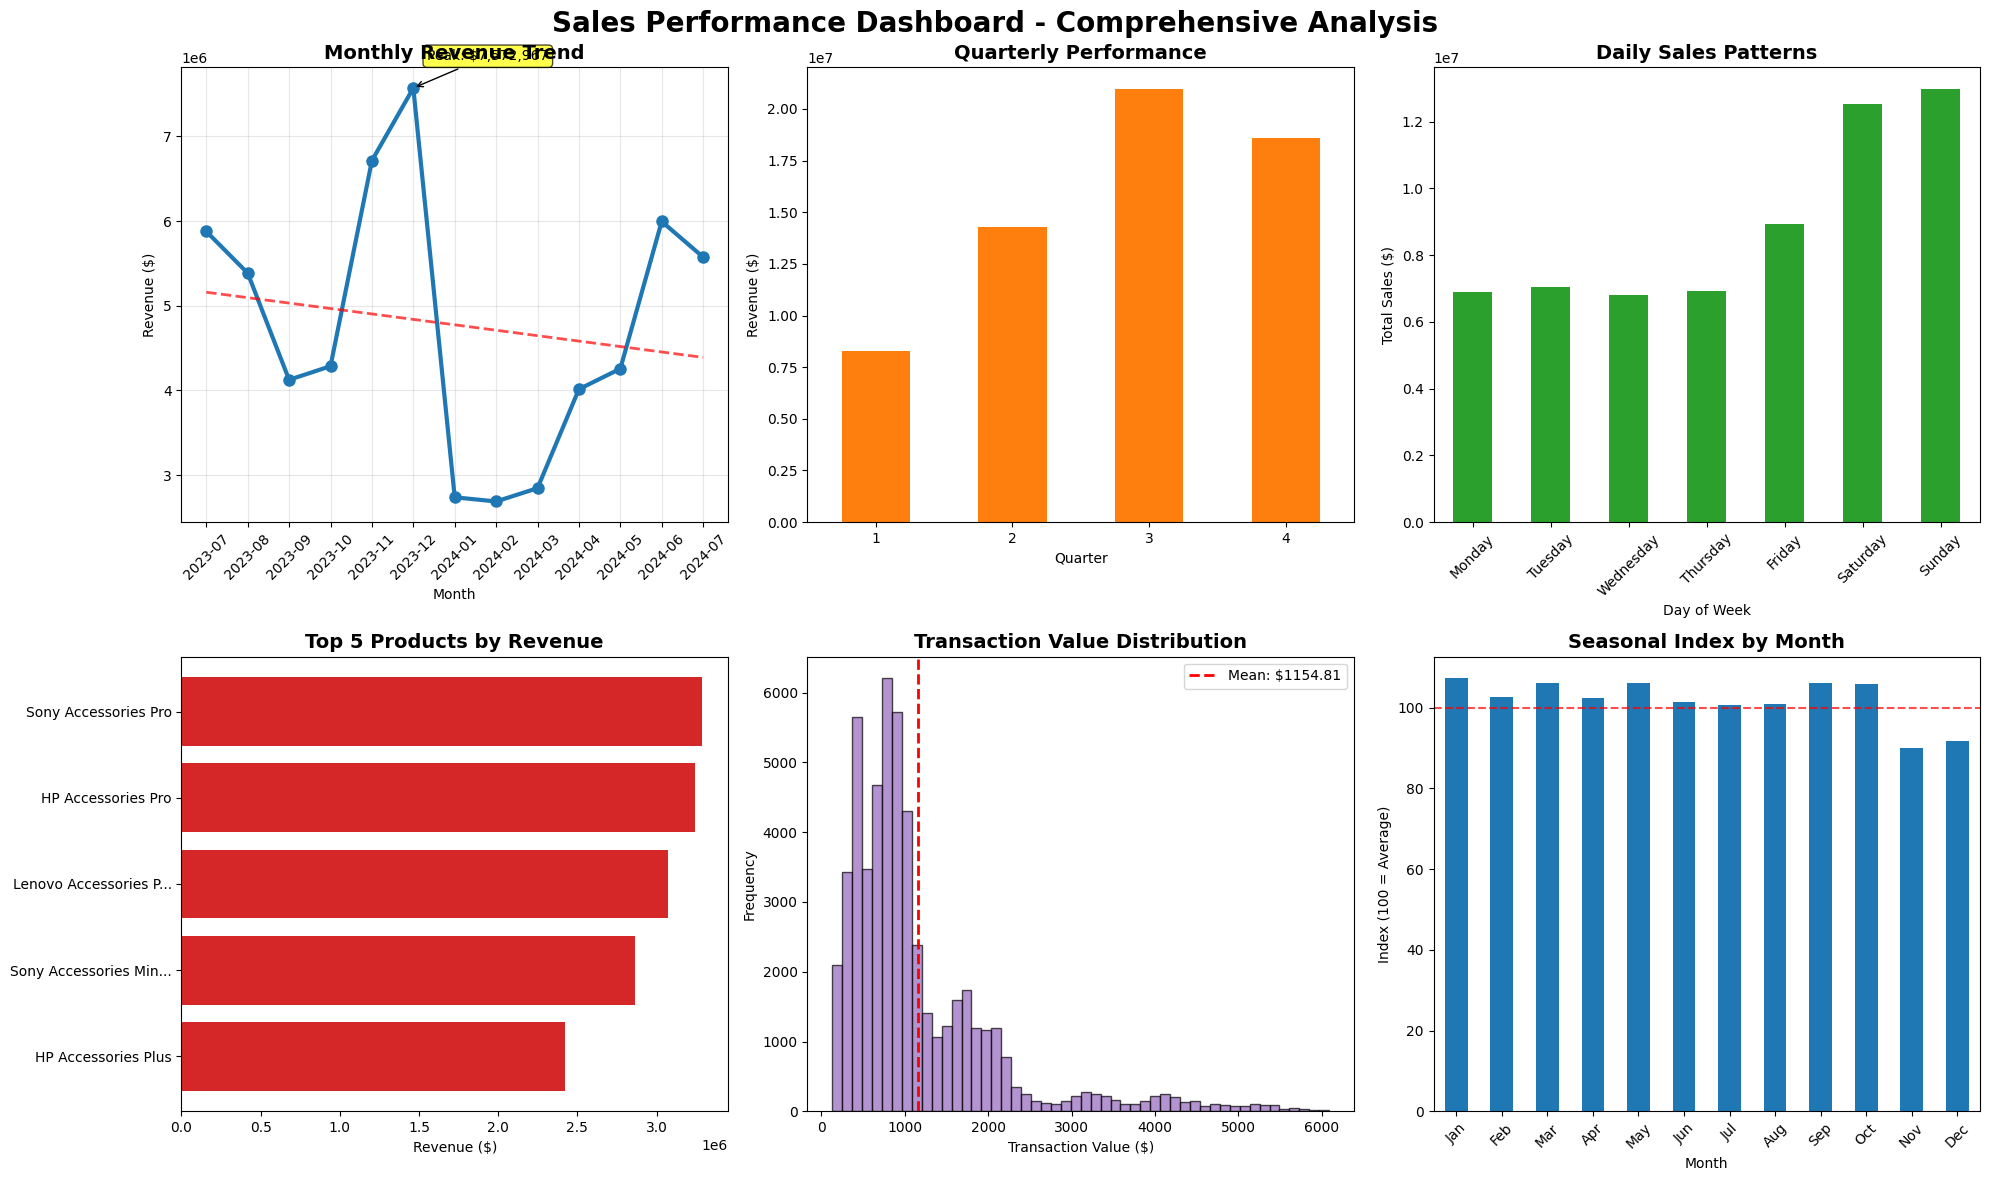

In [28]:
def create_enhanced_static_plots():
    """Create enhanced static visualizations."""
    
    # Set up the plotting style
    plt.style.use('default')
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Sales Performance Dashboard - Comprehensive Analysis', 
                 fontsize=20, fontweight='bold', y=0.98)
    
    # 1. Monthly Revenue Trend
    axes[0, 0].plot(monthly_summary['month_year'], monthly_summary['total_revenue'], 
                    marker='o', linewidth=3, markersize=8, color=colors[0])
    
    # Add trendline
    z = np.polyfit(range(len(monthly_summary)), monthly_summary['total_revenue'], 1)
    p = np.poly1d(z)
    axes[0, 0].plot(monthly_summary['month_year'], p(range(len(monthly_summary))), 
                    '--', alpha=0.7, color='red', linewidth=2)
    
    axes[0, 0].set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Month')
    axes[0, 0].set_ylabel('Revenue ($)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Highlight peak
    max_idx = monthly_summary['total_revenue'].idxmax()
    max_val = monthly_summary.loc[max_idx, 'total_revenue']
    max_month = monthly_summary.loc[max_idx, 'month_year']
    axes[0, 0].annotate(f'Peak: ${max_val:,.0f}', 
                       xy=(max_month, max_val),
                       xytext=(10, 20), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', color='black'))
    
    # 2. Quarterly Performance
    quarterly_sales['total_revenue'].plot(kind='bar', ax=axes[0, 1], color=colors[1])
    axes[0, 1].set_title('Quarterly Performance', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Quarter')
    axes[0, 1].set_ylabel('Revenue ($)')
    axes[0, 1].tick_params(axis='x', rotation=0)
    
    # 3. Daily Patterns
    daily_patterns['total_sales'].plot(kind='bar', ax=axes[0, 2], color=colors[2])
    axes[0, 2].set_title('Daily Sales Patterns', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Day of Week')
    axes[0, 2].set_ylabel('Total Sales ($)')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    # 4. Top Products
    top_5 = product_insights['top_revenue'].head(5)
    product_names_short = [name[:20] + '...' if len(name) > 20 else name 
                          for name in top_5.index.get_level_values('product_name')]
    
    y_pos = np.arange(len(product_names_short))
    axes[1, 0].barh(y_pos, top_5['total_sales'], color=colors[3])
    axes[1, 0].set_yticks(y_pos)
    axes[1, 0].set_yticklabels(product_names_short)
    axes[1, 0].invert_yaxis()
    axes[1, 0].set_title('Top 5 Products by Revenue', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Revenue ($)')
    
    # 5. Transaction Distribution
    axes[1, 1].hist(df_sales['total_sales'], bins=50, alpha=0.7, color=colors[4], edgecolor='black')
    mean_sales = df_sales['total_sales'].mean()
    axes[1, 1].axvline(mean_sales, color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: ${mean_sales:.2f}')
    axes[1, 1].set_title('Transaction Value Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Transaction Value ($)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    
    # 6. Seasonal Index
    seasonal_df.plot(x='month_name', y='seasonal_index', kind='bar', ax=axes[1, 2], 
                     color=colors[0], legend=False)
    axes[1, 2].axhline(y=100, color='red', linestyle='--', alpha=0.7)
    axes[1, 2].set_title('Seasonal Index by Month', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Month')
    axes[1, 2].set_ylabel('Index (100 = Average)')
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

# Create enhanced static plots
static_dashboard = create_enhanced_static_plots()
plt.show()

In [27]:
def save_analysis_results():
    """Save all analysis results to CSV files."""
    
    # Create export directory if it doesn't exist
    import os
    os.makedirs('../data/processed', exist_ok=True)
    os.makedirs('../exports', exist_ok=True)
    
    # Save key datasets
    monthly_summary.to_csv('../data/processed/monthly_summary_enhanced.csv', index=False)
    quarterly_sales.to_csv('../data/processed/quarterly_analysis_enhanced.csv')
    daily_patterns.to_csv('../data/processed/daily_patterns_enhanced.csv')
    product_insights['top_revenue'].to_csv('../data/processed/top_products_revenue_enhanced.csv')
    seasonal_df.to_csv('../data/processed/seasonal_indices_enhanced.csv', index=False)
    
    # Save interactive plots as HTML
    monthly_trend_fig.write_html('../exports/monthly_trend_interactive.html')
    product_chart_fig.write_html('../exports/top_products_interactive.html')
    heatmap_fig.write_html('../exports/seasonal_heatmap_interactive.html')
    dashboard_fig.write_html('../exports/interactive_dashboard.html')
    
    print("✓ All analysis results saved successfully!")
    
def generate_executive_summary():
    """Generate executive summary of key findings."""
    
    print("\n" + "="*60)
    print(" EXECUTIVE SUMMARY - KEY FINDINGS")
    print("="*60)
    
    # Key metrics
    total_revenue = df_sales['total_sales'].sum()
    total_transactions = len(df_sales)
    avg_order_value = df_sales['total_sales'].mean()
    
    print(f"\n FINANCIAL PERFORMANCE")
    print(f"   Total Revenue: ${total_revenue:,.2f}")
    print(f"   Total Transactions: {total_transactions:,}")
    print(f"   Average Order Value: ${avg_order_value:.2f}")
    
    print(f"\n GROWTH INSIGHTS")
    print(f"   Peak Month: {monthly_insights['peak_month']} (${monthly_insights['peak_revenue']:,.2f})")
    print(f"   Best Quarter: Q{best_quarter}")
    print(f"   Busiest Day: {busiest_day}")
    
    print(f"\n TOP PERFORMANCE")
    top_product = product_insights['top_revenue'].index[0][1][:50]
    top_product_revenue = product_insights['top_revenue'].iloc[0]['total_sales']
    print(f"   Top Product: {top_product}")
    print(f"   Top Product Revenue: ${top_product_revenue:,.2f}")
    
    print(f"\n RECOMMENDATIONS")
    print("   1. Focus marketing efforts during peak season months")
    print("   2. Optimize inventory for top-performing products") 
    print(f"   3. Leverage {busiest_day} traffic for promotions")
    print("   4. Investigate low-performing periods for improvement opportunities")
    
    print("\n" + "="*60)

# Execute final steps
save_analysis_results()
generate_executive_summary()

print("\n ANALYSIS COMPLETE!")
print(" Professional sales analysis notebook ready for portfolio")
print(" Interactive visualizations created with Plotly")
print(" Static dashboards created with Matplotlib")
print(" All results exported to CSV and HTML files")
print(" Executive summary generated")

✓ All analysis results saved successfully!

 EXECUTIVE SUMMARY - KEY FINDINGS

 FINANCIAL PERFORMANCE
   Total Revenue: $62,073,307.41
   Total Transactions: 53,752
   Average Order Value: $1154.81

 GROWTH INSIGHTS
   Peak Month: 2023-12 ($7,572,966.77)
   Best Quarter: Q3
   Busiest Day: Sunday

 TOP PERFORMANCE
   Top Product: Sony Accessories Pro
   Top Product Revenue: $3,286,167.67

 RECOMMENDATIONS
   1. Focus marketing efforts during peak season months
   2. Optimize inventory for top-performing products
   3. Leverage Sunday traffic for promotions
   4. Investigate low-performing periods for improvement opportunities


 ANALYSIS COMPLETE!
 Professional sales analysis notebook ready for portfolio
 Interactive visualizations created with Plotly
 Static dashboards created with Matplotlib
 All results exported to CSV and HTML files
 Executive summary generated
